# Predicting Employee Turnover

Data downloaded at <https://www.kaggle.com/ludobenistant/hr-analytics-1>.

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Data Preprocessing

In [59]:
df = pd.read_csv('HR_comma_sep.csv')

In [60]:
print('\033[1m\033[94mData Types:\n{}'.format('-' * 11))
print('\033[30m{}\n'.format(df.dtypes))
print('\033[1m\033[94mSum of null vaules in each column:\n{}'.format('-' * 34))
print('\033[30m{}'.format(df.isnull().sum()))

Data Types:
-----------
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

Sum of null vaules in each column:
----------------------------------
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


In [61]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [62]:
df = df.rename(columns={'sales': 'department'})

salary_map = {'low': 0, 'medium': 1, 'high': 2}
df['salary'] = df['salary'].map(salary_map)

df = pd.get_dummies(df, columns=['department'], drop_first=True)

In [63]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


## Modeling

In [64]:
pos = df[df['left'] == 1].shape[0]
neg = df[df['left'] == 0].shape[0]

In [65]:
print('Positive examples = {}'.format(pos))
print('Negative examples = {}'.format(neg))
print('Proportion of positive to negative examples = {:.2f}%'.format((pos / neg) * 100))


Positive examples = 3571
Negative examples = 11428
Proportion of positive to negative examples = 31.25%


Text(0.5,1,'Class counts')

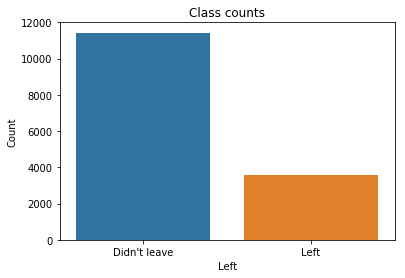

In [66]:
sns.countplot(df['left'])
plt.xticks((0, 1), ["Didn't leave", 'Left'])
plt.xlabel('Left')
plt.ylabel('Count')
plt.title('Class counts')

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Convert dataframe into numpy objects and split them into
# train and test sets: 80/20
X = df.loc[:, df.columns != 'left'].values
y = df.loc[:, df.columns == 'left'].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))
# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))
print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (11999, 17) (11999,)
Upsampled shape: (18284, 17) (18284,)
Downsampled shape: (5714, 17) (5714,)


Text(0.5,1,'PCA on training data')

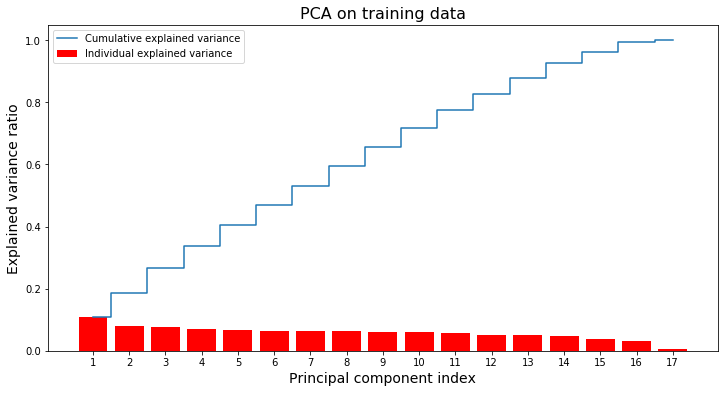

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Build PCA using standarized trained data
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))

cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 6))
plt.bar(range(1, 18), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 18), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 18))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16})

# Random Forest

In [71]:
# Build random forest classifier
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "Downsampled": (X_train_d, y_train_d)}
for method in methods_data.keys():
    pip_rf = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=500,
                                                  class_weight="balanced",
                                                  random_state=123))
    
    hyperparam_grid = {
        "randomforestclassifier__n_estimators": [10, 50, 100, 500],
        "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__criterion": ["gini", "entropy"]}
    
    gs_rf = GridSearchCV(pip_rf,
                         hyperparam_grid,
                         scoring="f1",
                         cv=10,
                         n_jobs=-1)
    
    gs_rf.fit(methods_data[method][0], methods_data[method][1])
    
    print("\033[1m" + "\033[0m" + "The best hyperparameters for {} data:".format(method))
    for hyperparam in gs_rf.best_params_.keys():
        print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_rf.best_params_[hyperparam])
        
    print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_rf.best_score_) * 100))

NameError: name 'make_pipeline' is not defined